# PCBO: Preferential Causal Bayesian Optimisation


## Import Libraries

In [119]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import networkx as nx
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.special import digamma
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Custom modules
from flows import real_nvp, residual_flow, neural_spline_flow, create_base_distribution
from prefflow import PrefFlow
from datasets import PCBO_Dataset_Three, PCBO_Dataset_Six, PCBO_ERDataset, PCBO_MedicalDataset
from parent_posterior import LocalParentPosterior, greedy_map_dag_from_edge_matrix, edge_matrix_from_locals
from parent_posterior_scalable import ScalableLocalParentPosterior
from baselines import CausalDiscoveryBaselines
from acquisition import pig_pairwise, eeig_pairwise

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Device and precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision_double = False
print(f"Using device: {device}")

Using device: cpu


## Problem Setup

In [120]:
# Problem parameters
d_utility = 2  # Dimensionality for utility function
n_initial_prefs = 20  # Initial preference data
n_iterations = 50  # PCBO iterations
k = 2  # k-wise preferences (pairwise)
flow_layers = 5  # Number of flow layers in the PrefFlow
flow_type = "neural_spline"  # "real_nvp", "residual", "neural_spline"

VERBOSE = False  # Set True for detailed per-node prints
LOG_EVERY = 10  # Number of iterations between logging
SAVE_FIGS = True

# Setup directory for saving figures
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Matplotlib style
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 14,
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'axes.axisbelow': True,
    'grid.alpha': 0.15,
    'figure.facecolor': 'white',
})

# Color scheme
COLORS = {
    'primary': '#2E3440',     # Dark
    'secondary': '#5E81AC',   # Blue
    'accent': '#BF616A',      # Red
    'success': '#A3BE8C',     # Green
    'warning': '#EBCB8B',     # Yellow
    'info': '#88C0D0',        # Light blue
}

In [121]:
# Create synthetic dataset
dataset = PCBO_Dataset_Six(
    n_queries=n_initial_prefs,
    noise_std=0.1,
    domain=(-2, 2),
    seed=42
)
print(f"Testing on {dataset.n_nodes}-node graph")

n_nodes = dataset.n_nodes  # Number of nodes in the causal graph
y_idx = n_nodes - 1  # Index of the target variable Y

true_adj, node_names = dataset.get_causal_graph()
print()
print(f"True causal graph:\n{true_adj.numpy()}")
print()
print(f"Node names: {node_names}")

Testing on 6-node graph

True causal graph:
[[0 0 0 1 0 1]
 [0 0 0 0 0 1]
 [0 0 0 1 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

Node names: ['X1', 'X2', 'X3', 'X4', 'X5', 'Y']


## Helper Classes and Functions

In [122]:
class PreferenceDataset:
    """Storage for preference comparisons"""
    def __init__(self, device):
        self.device = device
        self.feature_pairs = []  # List of (feat_winner, feat_loser) tuples
        self.labels = []  # List of labels (always 1.0 for winner first)
        self._X_cache = None
        self._Y_cache = None
        self._cache_valid = False
        
    def add_preference(self, outcome_winner, outcome_loser):
        """Add a new preference comparison"""
        feat_winner = intervention_to_utility_features(outcome_winner)
        feat_loser = intervention_to_utility_features(outcome_loser)
        self.feature_pairs.append((feat_winner, feat_loser))
        self.labels.append(1.0)
        self._cache_valid = False
        
    def add_from_query(self, query_data):
        """Add preferences from a query with k options"""
        outcomes = query_data['outcomes']
        winner_idx = query_data['winner_idx']
        
        # Compare winner against all losers
        for i in range(len(outcomes)):
            if i != winner_idx:
                self.add_preference(outcomes[winner_idx], outcomes[i])
        
    def get_batch(self, last_n=None):
        """Get preference data in PrefFlow format"""
        if len(self.feature_pairs) == 0:
            return None, None
            
        pairs = self.feature_pairs[-last_n:] if last_n else self.feature_pairs
        labels = self.labels[-last_n:] if last_n else self.labels
        
        n_comparisons = len(pairs)
        feat_dim = pairs[0][0].shape[0]
        X = torch.zeros(2, feat_dim, n_comparisons).to(self.device)
        
        for i, (feat1, feat2) in enumerate(pairs):
            X[0, :, i] = feat1.to(self.device)
            X[1, :, i] = feat2.to(self.device)
        
        Y = torch.tensor(labels, dtype=torch.float32).to(self.device)
        
        return X, Y
    
    def __len__(self):
        return len(self.feature_pairs)

def intervention_to_utility_features(intervention_outcome):
    """
    Map intervention outcomes to features for utility function
    Normalized to prevent numerical issues
    """
    if not isinstance(intervention_outcome, torch.Tensor):
        intervention_outcome = torch.tensor(intervention_outcome, dtype=torch.float32)
    
    # Determine which node is Y 
    y_value = intervention_outcome[y_idx]
    y_normalized = torch.tanh(y_value / 2.0)  # Assuming Y is roughly in [-2, 2]

    # Fixed intervention cost (also normalized)
    intervention_cost = 0.1
    
    # Match the dtype of the flow
    dtype = torch.float64 if precision_double else torch.float32
    
    features = torch.tensor([
        y_normalized.item() if isinstance(y_normalized, torch.Tensor) else y_normalized,
        intervention_cost
    ], dtype=dtype)
    
    return features

# Map a full outcome vector to (x_for_graph, y) for the ParentPosterior
def outcome_to_xy_local(outcome, lpp):
    x = outcome[lpp.parent_idx].unsqueeze(0)
    y = outcome[lpp.target_idx].reshape(1, 1)
    return x, y

# Helper to create locals for all targets except Y
def make_all_local_posts(n_nodes, y_idx=5):
    locals_dict = {}
    
    if n_nodes > 10:
        # Use MCMC-based scalable version
        PostClass = ScalableLocalParentPosterior
        print(f"Using scalable MCMC posterior for {n_nodes} nodes")
    else:
        # Use exact enumeration
        PostClass = LocalParentPosterior
        
    for t in range(n_nodes):
        if t == y_idx:
            parent_idx = [i for i in range(n_nodes) if i != y_idx]
            pi = 0.10
        else:
            parent_idx = [i for i in range(n_nodes) if i != t and i != y_idx]
            pi = 0.05
            
        kwargs = {
            'parent_idx': parent_idx,
            'target_idx': t,
            'a0': 2.0,
            'b0': 2.0,
            'tau2': 0.25,
            'prior_sparsity': pi,
            'device': device,
            'dtype': torch.float64
        }
        
        if n_nodes > 10:
            kwargs['max_parents'] = min(5, n_nodes - 1)
            
        locals_dict[t] = PostClass(**kwargs)
        
    return locals_dict

def is_dag(adj):
    """
    Check if adjacency matrix represents a DAG.
    Accepts numpy or torch; coerces to numpy float.
    """
    if 'torch' in str(type(adj)):
        A = adj.detach().cpu().numpy().astype(float)
    else:
        A = np.asarray(adj, dtype=float)
    n = A.shape[0]
    A_power = np.eye(n)
    for _ in range(n):
        A_power = A_power @ A
        if np.trace(A_power) > 0:
            return False
    return True

def log_line(it, shd, util_err, edge_err, n_prefs, sval):
    """Log current metrics in a formatted line"""
    print(f"[Current Metrics] SHD={shd:.2f} | Utility Error: {util_err:.3f} | Edge Error: {edge_err:.3f} | "
          f"Preferences: {n_prefs} | Noise Parameter (s): {sval:.3f}")

## PCBO Main Class

In [123]:
class PCBO:
    def __init__(self, dataset, device, n_iterations=50, flow_type="real_nvp", y_idx=y_idx):
        self.dataset = dataset
        self.device = device
        self.n_iterations = n_iterations
        self.flow_type = flow_type
        self.n_nodes = dataset.n_nodes
        self.y_idx = y_idx

        # Initialize components
        self.pref_flow = self._create_flow(flow_type)
        
        # Keep track of all local parent posteriors
        self.local_posts = make_all_local_posts(self.dataset.n_nodes, y_idx=self.y_idx)
        self.parent_posterior = self.local_posts[self.y_idx]  # Keep a convenience handle for Y

        # Get true adjacency matrix
        self.true_adj, self.node_names = dataset.get_causal_graph()
        
        # Efficient preference storage
        self.pref_dataset = PreferenceDataset(device)

        # DAG constraint tracking
        self.current_dag = None

        # Identify controllable nodes (all except Y)
        self.controllable = [i for i in range(self.n_nodes) if i != self.y_idx]

        # Storage for tracking progress
        self.iteration_history = []
        self.graph_distances = []
        self.utility_errors = []
        self.edge_prob_errors = []
        self.selected_interventions = []
        self.s_history_epochs = []  # noise (s) histories per epoch
        self.s_history_iter = []  # noise (s) histories per PCBO iteration

        # Stability tracking
        self.flow_stable = True
        self.instability_count = 0
        self.reinitialization_count = 0
        
    def _create_flow(self, flow_type="real_nvp"):
        """Create a fresh PrefFlow model"""
        # Local precision setting for this flow
        local_precision = precision_double
        if flow_type == "neural_spline" or flow_type == "residual":
            local_precision = False
            
        base_dist = create_base_distribution(d_utility, self.device, local_precision)
        
        if flow_type == "neural_spline":
            nf_model = neural_spline_flow(
                K=max(2, flow_layers // 2),  # Fewer layers for stability
                D=d_utility,
                q0=base_dist,
                device=self.device,
                precision_double=False,
                hidden_layers=2,
                hidden_units=64
            )
            flow_precision = False

        elif	flow_type == "residual":
            nf_model = residual_flow(
                K=flow_layers,
                D=d_utility,
                q0=base_dist,
                device=self.device,
                precision_double=False,
                hidden_layers=2,
                hidden_units=64,
            )
            flow_precision = False
            
        else:
            nf_model = real_nvp(flow_layers, d_utility, base_dist, self.device, precision_double)
            flow_precision = precision_double

        pref_flow = PrefFlow(nf_model, s=1.0, D=d_utility, ranking=False,
                             device=self.device, precision_double=flow_precision)
        return pref_flow
        
    def train_utility_on_preferences(self, n_epochs=50, lr=1e-3, batch_size=None):
        """Train PrefFlow based on preference data"""
        # Use all available data if batch_size not specified
        if batch_size is None:
            batch_size = min(40, len(self.pref_dataset))
        
        # Get data from preference dataset
        X, Y = self.pref_dataset.get_batch(last_n=batch_size)
        if X is None or Y is None:
            print("    No preference data available")
            return []
        
        base_lr = lr
        param_groups = [
            {"params": [p for n,p in self.pref_flow.named_parameters() if n != "s_raw"],
             "lr": base_lr, "weight_decay": 1e-5},
            {"params": [self.pref_flow.s_raw],
             "lr": base_lr * 2, "weight_decay": 0.0},
        ]
        optimizer = torch.optim.Adam(param_groups)

        # Cosine annealing scheduler
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-5)
        
        losses = []
        best_loss = float("inf")
        patience = 10
        patience_counter = 0

        for epoch in range(n_epochs):
            optimizer.zero_grad()
            
            try:
                # Compute loss
                log_posterior = self.pref_flow.logposterior((X, Y))
                
                # Check for NaN
                if torch.isnan(log_posterior) or torch.isinf(log_posterior):
                    self.flow_stable = False
                    self.instability_count += 1
                    
                    if self.instability_count > 3:
                        print(f"    Flow unstable, reinitializing...")
                        self._reinitialize_flow()
                        return self.train_utility_on_preferences(n_epochs//2, lr*0.5, batch_size)
                    continue

                loss = -log_posterior / batch_size

                # Only backprop if loss is valid and reasonable
                if not torch.isnan(loss) and not torch.isinf(loss) and abs(loss.item()) < 1e4:
                    loss.backward()
                    
                    # Gradient clipping for stability
                    torch.nn.utils.clip_grad_norm_(self.pref_flow.parameters(), max_norm=5.0)
                    
                    optimizer.step()
                    scheduler.step()
                    losses.append(loss.item())
                    
                    # Record s each epoch
                    self.s_history_epochs.append(float(self.pref_flow.s.item()))
                    
                    # Reset instability count on successful training
                    self.flow_stable = True
                    self.instability_count = 0

                    # Early stopping
                    if loss.item() < best_loss:
                        best_loss = loss.item()
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            print(f"    Early stopping at epoch {epoch}")
                            break
                    
                    if epoch % 20 == 0:
                        current_lr = scheduler.get_last_lr()[0]
                        print(f"    Epoch {epoch}, Loss: {loss.item():.4f}, LR: {current_lr:.4f}")

            except Exception as e:
                print(f"    Error during training: {e}")
                self.instability_count += 1
                if self.instability_count > 3:
                    self._reinitialize_flow()
                    return losses
                    
        return losses
    
    def _reinitialize_flow(self):
        """Reinitialize the flow if it becomes unstable"""
        print("    Creating new flow due to instability...")
        # Mark reset in histories (NaN sentinel)
        self.s_history_epochs.append(float('nan'))
        self.s_history_iter.append(float('nan'))
        
        self.pref_flow = self._create_flow(self.flow_type)
        self.warmup_flow(n_synthetic=50)
        self.flow_stable = True
        self.reinitialization_count += 1
    
    def select_next_intervention(self, current_iteration=0, n_candidates=30):
        """Select next intervention using PCBO acquisition functions"""
        # Generate candidate interventions
        cand_interventions = []
        cand_features = []
        cand_outcomes = []

        # Ensure coverage of all nodes
        n_per_node = max(1, n_candidates // len(self.controllable))
        for node_idx in self.controllable:
            for _ in range(n_per_node):
                value = np.random.uniform(-2, 2)
                intervention = (node_idx, value)
                cand_interventions.append(intervention)
                
                # Execute intervention to get outcome
                outcome = self.dataset._compute_intervention_outcome(node_idx, value)
                cand_outcomes.append(outcome)

                # Convert to utility features
                features = intervention_to_utility_features(outcome)
                cand_features.append(features)

        # Targeted exploration for early iterations
        if current_iteration < 10:
            target_node = self.controllable[current_iteration % len(self.controllable)]
            for _ in range(5):  # Add a few extra candidates for target_node
                value = np.random.uniform(-2, 2)
                intervention = (target_node, value)
                cand_interventions.append(intervention)
                outcome = self.dataset._compute_intervention_outcome(target_node, value)
                cand_outcomes.append(outcome)
                features = intervention_to_utility_features(outcome)
                cand_features.append(features)
        
        # Stack features
        cand_features = torch.stack(cand_features).to(self.device)

        # -------- Stage 1: Select Anchor Intervention --------
        # Score = total edge-entropy reduction across all locals if we executed this intervention
        try:
            with torch.no_grad():
                base_entropy = 0.0
                for lp in self.local_posts.values():
                    pj = lp.edge_posterior()
                    eps = torch.tensor(1e-12, dtype=pj.dtype, device=pj.device)
                    H = -(pj * torch.log(pj + eps) + (1 - pj) * torch.log(1 - pj + eps))
                    base_entropy += float(H.sum().cpu().item())

                entropy_after = []
                for out, (node, _) in zip(cand_outcomes, cand_interventions):
                    H_sum = 0.0
                    for lp in self.local_posts.values():
                        H_sum += float(lp.peek_update_edge_entropy_full(out, intervened_idx=node).cpu().item())
                    entropy_after.append(H_sum)

                entropy_after = np.array(entropy_after)
                eig_single = base_entropy - entropy_after  # Higher is better
        except Exception as e:
            print(f"    Anchor scoring failed ({e}) — choosing random anchor.")
            eig_single = np.random.randn(len(cand_interventions)) * 1e-6

        # Light exploration bonus to avoid repeatedly choosing the same node
        bonus = self._compute_exploration_bonus(cand_interventions)
        anchor_scores = eig_single + 0.05 * bonus

        # If flow is unstable, we still pick the anchor by graph criteria
        anchor_idx = int(np.argmax(anchor_scores))
        anchor_interv = cand_interventions[anchor_idx]
        anchor_out = cand_outcomes[anchor_idx]
        anchor_feat = cand_features[anchor_idx].unsqueeze(0)  # (1, d_feat)

        # -------- Stage 2: Choose Opponent (preference + graph blend) --------
        # If flow unstable, fallback to random opponent (not equal to anchor)
        if not self.flow_stable:
            print("    Flow unstable — picking random opponent.")
            opp_pool = [i for i in range(len(cand_interventions)) if i != anchor_idx]
            opponent_idx = int(np.random.choice(opp_pool))
            return anchor_interv, cand_interventions[opponent_idx]

        try:
            with torch.no_grad():
                # PIG relative to anchor (utility/model-driven)
                pig = pig_pairwise(
                    self.pref_flow,
                    anchor_feat,
                    cand_features,
                    self.pref_flow.s.item()
                )

                # EEIG relative to anchor (structure-driven, local decomposition)
                eeig_total = None
                for lp in self.local_posts.values():
                    ax_lp, ay_lp = outcome_to_xy_local(anchor_out, lp)
                    cand_xy_lp = [outcome_to_xy_local(o, lp) for o in cand_outcomes]
                    eeig_lp = eeig_pairwise(
                        self.pref_flow,
                        lp,
                        anchor_feat,
                        cand_features,
                        self.pref_flow.s.item(),
                        anchor_xy=(ax_lp, ay_lp),
                        cand_xy=cand_xy_lp
                    )
                    eeig_total = eeig_lp if eeig_total is None else (eeig_total + eeig_lp)
                eeig = eeig_total / max(1, len(self.local_posts))

            # Normalize both (safe min-max)
            pig = pig.copy()
            eeig = eeig.copy()
            pig = (pig - pig.min()) / (pig.max() - pig.min() + 1e-12)
            eeig = (eeig - eeig.min()) / (eeig.max() - eeig.min() + 1e-12)

            # Blend
            alpha = self._compute_acquisition_weight(current_iteration)
            blended = alpha * pig + (1 - alpha) * eeig

            # Exploration bonus and jitter
            blended += 0.1 * self._compute_exploration_bonus(cand_interventions)
            blended += 0.01 * np.random.randn(len(blended))

            # Never choose the anchor as opponent
            blended[anchor_idx] = -1e9

            opponent_idx = int(np.argmax(blended))

            # Store diagnostics
            self.last_acquisition_info = {
                "anchor_idx": anchor_idx,
                "opponent_idx": opponent_idx,
                "anchor_scores_single_EIG": eig_single,
                "pig": pig,
                "eeig": eeig,
                "alpha": alpha,
            }

            print(f"    Anchor: node {anchor_interv[0]}, val {anchor_interv[1]:.3f}")
            print(f"    Opponent: node {cand_interventions[opponent_idx][0]}, val {cand_interventions[opponent_idx][1]:.3f}")
            print(f"    Alpha (utility weight): {alpha:.3f}")

            return anchor_interv, cand_interventions[opponent_idx]

        except Exception as e:
            print(f"    Opponent scoring failed ({e}) — random opponent fallback.")
            opp_pool = [i for i in range(len(cand_interventions)) if i != anchor_idx]
            opponent_idx = int(np.random.choice(opp_pool))
            return anchor_interv, cand_interventions[opponent_idx]

    def _compute_acquisition_weight(self, iteration):
        """
        Compute adaptive weight for PIG (utility learning)
        Early: Low alpha (focus on causal discovery via EEIG)
        Late: High alpha (focus on utility learning via PIG)
        """
        t = iteration / max(1, self.n_iterations - 1)
        # Three-phase scheduling
        if t < 0.2:  # Early phase: focus on structure
            return 0.2 + 0.3 * (t / 0.2)  # 20% to 50%
        elif t < 0.7:  # Middle phase: balanced
            return 0.5
        else:  # Late phase: focus on utility
            return 0.5 + 0.4 * ((t - 0.7) / 0.3)  # 50% to 90%

    def _compute_exploration_bonus(self, cand_interventions):
        """
        Compute exploration bonus for each candidate based on novelty
        """
        if len(self.selected_interventions) == 0:
            return np.zeros(len(cand_interventions))
            
        bonuses = []
        
        for node_idx, value in cand_interventions:
            # Count previous interventions on this node
            node_count = sum(1 for n, v in self.selected_interventions if n == node_idx)
            node_novelty = 1.0 / (1.0 + node_count)
            
            # Check value novelty
            same_node_values = [v for n, v in self.selected_interventions if n == node_idx]
            if same_node_values:
                min_distance = min(abs(value - v) for v in same_node_values)
                value_novelty = np.tanh(min_distance)
            else:
                value_novelty = 1.0
            
            # Combined novelty score
            bonus = 0.7 * node_novelty + 0.3 * value_novelty
            bonuses.append(bonus)
        
        return np.array(bonuses)
    
    def _evaluate_current_performance(self):
        """
        Evaluate against the single source of truth: the projected DAG.
        """
        if self.current_dag is None:
            learned_adj = self.update_graph_with_dag_constraint()
        else:
            learned_adj = self.current_dag

        # SHD vs true adjacency
        shd = torch.sum(torch.abs(learned_adj - self.true_adj)).item()

        # Smooth edge-prob error averaged across all locals (diagnostic only)
        smooth_errors = []
        for lp in self.local_posts.values():
            probs = lp.edge_posterior()
            true_vec = self.true_adj[lp.parent_idx, lp.target_idx].to(probs.dtype)
            smooth_errors.append(torch.mean(torch.abs(probs - true_vec)).item())
        edge_prob_error = float(np.mean(smooth_errors)) if smooth_errors else 0.0

        # Utility prediction error
        util_error = self._evaluate_utility_accuracy()
        return shd, util_error, edge_prob_error
    
    def _evaluate_utility_accuracy(self, n_test=10):
        """Test preference prediction accuracy"""
        if not self.flow_stable or len(self.pref_dataset) < 10:
            return 1.0
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for _ in range(n_test):
                # Generate two random interventions
                interventions = []
                outcomes = []
                features = []
                
                for _ in range(2):
                    node = np.random.choice(self.controllable)
                    value = np.random.uniform(-2, 2)
                    outcome = self.dataset._compute_intervention_outcome(node, value)
                    
                    interventions.append((node, value))
                    outcomes.append(outcome)
                    features.append(intervention_to_utility_features(outcome))
                
                # True preference
                true_utils = [self.dataset._true_utility(out, inter[0]) 
                             for out, inter in zip(outcomes, interventions)]
                true_pref = true_utils[0] > true_utils[1]
                
                # Learned preference
                try:
                    feat_tensor = torch.stack(features).to(self.device)
                    log_utils, _ = self.pref_flow.f(feat_tensor)
                    
                    if not torch.any(torch.isnan(log_utils)):
                        learned_pref = log_utils[0] > log_utils[1]
                        if true_pref == learned_pref:
                            correct += 1
                        total += 1
                except:
                    pass
        
        return 1.0 - (correct / total if total > 0 else 0)

    def run_iteration(self, all_queries, current_iteration):
        """
        Run one PCBO iteration:
        - Trains preference flow if enough preferences
        - Updates causal posterior (periodically)
        - Selects next intervention
        - Executes only the chosen intervention
        - Creates a preference query using a random opponent
        - Adds the executed data point to causal buffer
        - Updates causal posterior in batch
        """
        # Step 1: Update utility function from preferences
        print("  Updating utility function...")
        if len(self.pref_dataset) >= 10:
            self.train_utility_on_preferences()
            
        # Snapshot s for this iteration
        self.s_history_iter.append(float(self.pref_flow.s.item()))

        # Step 2: Select next intervention pair via acquisition function
        print("  Selecting next intervention pair...")
        anchor_intervention, opponent_intervention = self.select_next_intervention(current_iteration)
        self.selected_interventions.append(anchor_intervention)

        # Step 3: Execute both interventions (anchor + chosen opponent)
        a_node, a_val = anchor_intervention
        b_node, b_val = opponent_intervention
        anchor_outcome = self.dataset._compute_intervention_outcome(a_node, a_val)
        opponent_outcome = self.dataset._compute_intervention_outcome(b_node, b_val)

        # Feed results to locals
        self._add_datapoint_to_locals(anchor_outcome, a_node)
        self._add_datapoint_to_locals(opponent_outcome, b_node)

        # Step 4: Create the observed preference for the executed pair
        u_a = self.dataset._true_utility(anchor_outcome, a_node)
        u_b = self.dataset._true_utility(opponent_outcome, b_node)
        winner_idx = 0 if u_a > u_b else 1

        first_query = {
            "interventions": [(a_node, a_val), (b_node, b_val)],
            "outcomes": torch.stack([anchor_outcome, opponent_outcome]),
            "winner_idx": winner_idx,
            "utilities": torch.tensor([u_a, u_b]),
        }

        # Step 5: Add to preference dataset (for PrefFlow)
        self.pref_dataset.add_from_query(first_query)

        # Extra comparisons for data efficiency (anchor-conditioned)
        extra_comparisons = self.generate_preference_batch(
            anchor_intervention=anchor_intervention,
            n_comparisons=3,
            n_candidates=80,
            diversity_tau=0.25
        )

        for comp in extra_comparisons:
            extra_query = {
                "interventions": [comp["main_intervention"], comp["alt_intervention"]],
                "outcomes": torch.stack([comp["main_outcome"], comp["alt_outcome"]]),
                "winner_idx": comp["winner_idx"],
                "utilities": comp["utilities"],
            }
            self.pref_dataset.add_from_query(extra_query)

        # Step 6: Update local posteriors with newly added data
        for lp in self.local_posts.values():
            if lp.num_datapoints() >= 2:
                lp.update_posterior()
                
        # Step 7: Project to DAG
        self.update_graph_with_dag_constraint()

        # Step 8: Evaluate causal performance
        _, _, edge_prob_error = self._evaluate_current_performance()
        if edge_prob_error < 0.1 and current_iteration > 20:
            print("  Causal structure converged! Focusing on utility learning.")
            self._force_utility_focus = True

        return first_query
    
    def get_learned_dag(self):
        """Get the learned DAG (guaranteed acyclic)"""
        if self.current_dag is None:
            self.update_graph_with_dag_constraint()
        return self.current_dag
    
    def warmup_flow(self, n_synthetic=100):
        """Warmup flow with synthetic preferences"""
        print("  Warming up flow with synthetic data...")
        
        # Generate synthetic preferences
        for _ in range(n_synthetic):
            # Random interventions
            node1 = np.random.randint(0, self.n_nodes)
            val1 = np.random.uniform(-2, 2)
            out1 = self.dataset._compute_intervention_outcome(node1, val1)
            
            node2 = np.random.randint(0, self.n_nodes)
            val2 = np.random.uniform(-2, 2)
            out2 = self.dataset._compute_intervention_outcome(node2, val2)
            
            # True preference
            util1 = self.dataset._true_utility(out1, node1)
            util2 = self.dataset._true_utility(out2, node2)
            
            if util1 > util2:
                self.pref_dataset.add_preference(out1, out2)
            else:
                self.pref_dataset.add_preference(out2, out1)
        
        # Train on synthetic data
        self.train_utility_on_preferences(n_epochs=50, lr=1e-3)
        
        # Clear synthetic data
        self.pref_dataset = PreferenceDataset(self.device)
        print("  Warmup complete")
        
    def generate_preference_batch(
        self,
        anchor_intervention,
        n_comparisons: int = 4,
        n_candidates: int = 80,
        diversity_tau: float = 0.25,  # Penalty strength for near-duplicate opponents
    ):
        """
        Generate a batch of preference comparisons for a fixed anchor intervention.

        Returns: list of dicts, each with:
          {
            'main_intervention': (node, value),
            'alt_intervention':  (node, value),
            'main_outcome':  tensor(d,),
            'alt_outcome':   tensor(d,),
            'winner_idx':    0 or 1,
            'utilities':     tensor([u_main, u_alt]),
          }
        """
        # 0) Prepare anchor
        a_node, a_val = anchor_intervention
        anchor_out = self.dataset._compute_intervention_outcome(a_node, a_val)
        anchor_feat = intervention_to_utility_features(anchor_out).to(self.device).unsqueeze(0)  # (1, d_feat)

        # 1) Build opponent pool
        cand_intervs = []
        cand_outcomes = []
        cand_feats = []
        per_node = max(1, n_candidates // len(self.controllable))
        for node in self.controllable:
            for _ in range(per_node):
                val = np.random.uniform(-2, 2)
                # skip exact duplicate of anchor
                if node == a_node and abs(val - a_val) < 1e-9:
                    continue
                cand_intervs.append((node, val))
                out = self.dataset._compute_intervention_outcome(node, val)
                cand_outcomes.append(out)
                cand_feats.append(intervention_to_utility_features(out))

        if len(cand_intervs) == 0:
            # degenerate fallback
            return []

        feats_tensor = torch.stack(cand_feats).to(self.device)  # (N, d_feat)

        # 2) Score opponents (relative to anchor) by blended PIG + EEIG
        if not self.flow_stable:
            # Flow unstable -> random opponents (still diverse)
            raw_scores = np.random.randn(len(cand_intervs)) * 1e-6
        else:
            try:
                with torch.no_grad():
                    # PIG (utility-driven)
                    pig = pig_pairwise(
                        self.pref_flow,
                        anchor_feat,
                        feats_tensor,
                        self.pref_flow.s.item()
                    )  # (N,)

                    # EEIG (structure-driven; decompose across local posteriors)
                    eeig_total = None
                    for lp in self.local_posts.values():
                        ax_lp, ay_lp = outcome_to_xy_local(anchor_out, lp)
                        cand_xy_lp = [outcome_to_xy_local(o, lp) for o in cand_outcomes]
                        eeig_lp = eeig_pairwise(
                            self.pref_flow,
                            lp,
                            anchor_feat,
                            feats_tensor,
                            self.pref_flow.s.item(),
                            anchor_xy=(ax_lp, ay_lp),
                            cand_xy=cand_xy_lp
                        )
                        eeig_total = eeig_lp if eeig_total is None else (eeig_total + eeig_lp)
                    eeig = eeig_total / max(1, len(self.local_posts))

                # Safe min–max for each score
                pig = pig.copy(); eeig = eeig.copy()
                pig = (pig - pig.min()) / (pig.max() - pig.min() + 1e-12)
                eeig = (eeig - eeig.min()) / (eeig.max() - eeig.min() + 1e-12)

                alpha = self._compute_acquisition_weight(
                    len(self.iteration_history) if hasattr(self, "iteration_history") else 0
                )
                raw_scores = alpha * pig + (1 - alpha) * eeig

                # small exploration bonus + jitter
                raw_scores += 0.1 * self._compute_exploration_bonus(cand_intervs)
                raw_scores += 0.01 * np.random.randn(len(raw_scores))

            except Exception as e:
                print(f"    Batch opponent scoring failed ({e}) — randomizing.")
                raw_scores = np.random.randn(len(cand_intervs)) * 1e-6

        # 3) Greedy top-K with diversity (penalize near-duplicate opponents)
        # Distance in (node,value) space; node mismatch encourages diversity
        def interv_distance(iv1, iv2):
            (n1, v1), (n2, v2) = iv1, iv2
            return (0.0 if n1 == n2 else 1.0) + abs(v1 - v2)

        selected_idx = []
        scores = raw_scores.copy()

        for _ in range(min(n_comparisons, len(cand_intervs))):
            j = int(np.argmax(scores))
            selected_idx.append(j)
            # Diversity penalty for remaining
            for i in range(len(cand_intervs)):
                if i in selected_idx:
                    continue
                dist = interv_distance(cand_intervs[i], cand_intervs[j])
                # Larger dist -> smaller penalty; clamp to avoid huge subtractions
                penalty = diversity_tau / (dist + 1e-6)
                scores[i] -= penalty
            scores[j] = -1e9  # Don't pick again

        # 4) Execute pairs, compute preferences, update causal stats for opponents
        batch = []
        for j in selected_idx:
            b_node, b_val = cand_intervs[j]
            b_out = cand_outcomes[j]

            u_a = self.dataset._true_utility(anchor_out, a_node)
            u_b = self.dataset._true_utility(b_out, b_node)
            winner_idx = 0 if u_a > u_b else 1

            comp = {
                "main_intervention": (a_node, a_val),
                "alt_intervention": (b_node, b_val),
                "main_outcome": anchor_out,
                "alt_outcome": b_out,
                "winner_idx": winner_idx,
                "utilities": torch.tensor([u_a, u_b]),
            }
            batch.append(comp)

            # Also feed opponent outcome into locals for causal updates
            self._add_datapoint_to_locals(b_out, b_node)

        return batch
    
    def _add_datapoint_to_locals(self, outcome, do_idx):
        for lp in self.local_posts.values():
            # Skip if we intervened on the target itself
            if do_idx == lp.target_idx:
                continue
            lp.add_datapoint_full(outcome, do_idx)

    def update_graph_with_dag_constraint(self, temperature = 1.5, indegree_cap = None):
        """
        Build edge prob matrix P from locals, (optionally) soften with a temperature,
        then project to a DAG using greedy_map_dag_from_edge_matrix.
        """
        # 1) Edge probs from all local posteriors
        local_list = list(self.local_posts.values())
        P = edge_matrix_from_locals(local_list, d=self.n_nodes, device=self.device, dtype=torch.float64)

        # 2) (Optional) soften to avoid overconfidence before ranking by logit
        if temperature is not None and temperature > 0:
            # logits -> temperature -> probs again
            P_eps = P.clamp(1e-12, 1 - 1e-12)
            logits = torch.log(P_eps) - torch.log(1 - P_eps)
            P = torch.sigmoid(logits / temperature)

        # 3) Project to a DAG
        A = greedy_map_dag_from_edge_matrix(
            P, score="logit", indegree_cap=indegree_cap, forbid_self_loops=True
        ).to(dtype=torch.int64)

        self.current_dag = A
        return A

## Run PCBO

In [124]:
# Initialize PCBO
pcbo = PCBO(dataset, device, n_iterations=n_iterations, flow_type=flow_type)

print("Adding initial diverse interventions...")
for node in range(n_nodes):
    for value in [-1.5, 0.0, 1.5]:
        outcome = dataset._compute_intervention_outcome(node, value)
        pcbo._add_datapoint_to_locals(outcome, node)
            
# Update posteriors immediately
for lp in pcbo.local_posts.values():
    if lp.num_datapoints() >= 3:
        lp.update_posterior()

# Warmup flow with synthetic preferences
pcbo.warmup_flow(n_synthetic=100)

# Use initial preferences from dataset
all_queries = list(dataset.queries)
for query in all_queries:
    pcbo.pref_dataset.add_from_query(query)

# Run PCBO iterations
print("Starting PCBO iterations...")
for iteration in tqdm(range(n_iterations)):
    print(f"\nIteration {iteration + 1}/{n_iterations}")
    
    # Run one iteration
    new_query = pcbo.run_iteration(all_queries, iteration)
    all_queries.append(new_query)
    
    # Evaluate performance
    shd, util_error, edge_prob_error = pcbo._evaluate_current_performance()
    pcbo.iteration_history.append(iteration)
    pcbo.graph_distances.append(shd)
    pcbo.utility_errors.append(util_error)
    pcbo.edge_prob_errors.append(edge_prob_error)
    
    # Print progress every 10 iterations
    if (iteration + 1) % LOG_EVERY == 0:
        log_line(iteration + 1, shd, util_error, edge_prob_error, len(pcbo.pref_dataset), pcbo.pref_flow.s.item())
        if VERBOSE:
            for tgt, lp in pcbo.local_posts.items():
                probs = lp.edge_posterior().cpu().numpy()
                pnames = [pcbo.node_names[i] for i in lp.parent_idx]
                tname = pcbo.node_names[lp.target_idx]
                print(f"  {tname}: P(parents->{tname}) = {dict(zip(pnames, np.round(probs,3)))}")
                print(f"  {tname}: MAP parents = {lp.most_probable_set()}")

Adding initial diverse interventions...
  Warming up flow with synthetic data...
    Epoch 0, Loss: 2.5295, LR: 0.0010
    Epoch 20, Loss: -0.7408, LR: 0.0006
    Epoch 40, Loss: -2.1128, LR: 0.0001
  Warmup complete
Starting PCBO iterations...


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1/50
  Updating utility function...
    Epoch 0, Loss: -2.2786, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 2, val -1.348
    Opponent: node 0, val -1.609
    Alpha (utility weight): 0.200


  2%|▏         | 1/50 [00:03<02:58,  3.64s/it]


Iteration 2/50
  Updating utility function...
    Epoch 0, Loss: -0.3514, LR: 0.0010
    Epoch 20, Loss: -2.3846, LR: 0.0006
    Early stopping at epoch 37
  Selecting next intervention pair...
    Anchor: node 2, val 1.728
    Opponent: node 1, val 1.403
    Alpha (utility weight): 0.231


  4%|▍         | 2/50 [00:07<02:58,  3.71s/it]


Iteration 3/50
  Updating utility function...
    Epoch 0, Loss: -2.0642, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 4, val 1.777
    Opponent: node 0, val -1.259
    Alpha (utility weight): 0.261


  6%|▌         | 3/50 [00:10<02:50,  3.63s/it]


Iteration 4/50
  Updating utility function...
    Epoch 0, Loss: -0.8637, LR: 0.0010
    Epoch 20, Loss: -1.9149, LR: 0.0006
    Epoch 40, Loss: -2.7255, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 3, val 0.526
    Opponent: node 3, val 1.636
    Alpha (utility weight): 0.292


  8%|▊         | 4/50 [00:14<02:50,  3.70s/it]


Iteration 5/50
  Updating utility function...
    Epoch 0, Loss: -2.8782, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 1, val -1.435
    Opponent: node 4, val -0.730
    Alpha (utility weight): 0.322


 10%|█         | 5/50 [00:18<02:49,  3.76s/it]


Iteration 6/50
  Updating utility function...
    Epoch 0, Loss: -0.2750, LR: 0.0010
    Epoch 20, Loss: -1.8795, LR: 0.0006
    Epoch 40, Loss: -2.9052, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 0, val 1.087
    Opponent: node 0, val 1.616
    Alpha (utility weight): 0.353


 12%|█▏        | 6/50 [00:22<02:52,  3.92s/it]


Iteration 7/50
  Updating utility function...
    Epoch 0, Loss: -2.8889, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 0, val 1.816
    Opponent: node 1, val -1.313
    Alpha (utility weight): 0.384


 14%|█▍        | 7/50 [00:26<02:46,  3.88s/it]


Iteration 8/50
  Updating utility function...
    Epoch 0, Loss: -1.2597, LR: 0.0010
    Epoch 20, Loss: -1.8217, LR: 0.0006
    Epoch 40, Loss: -2.5622, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 0, val 0.591
    Opponent: node 3, val 1.128
    Alpha (utility weight): 0.414


 16%|█▌        | 8/50 [00:30<02:41,  3.85s/it]


Iteration 9/50
  Updating utility function...
    Epoch 0, Loss: -2.7524, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 3, val 1.928
    Opponent: node 3, val -1.010
    Alpha (utility weight): 0.445


 18%|█▊        | 9/50 [00:34<02:43,  3.99s/it]


Iteration 10/50
  Updating utility function...
    Epoch 0, Loss: -1.0779, LR: 0.0010
    Epoch 20, Loss: -2.0169, LR: 0.0006
    Epoch 40, Loss: -2.4673, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 3, val -1.320
    Opponent: node 4, val 0.315
    Alpha (utility weight): 0.476


 20%|██        | 10/50 [00:39<02:47,  4.18s/it]

[Current Metrics] SHD=9.00 | Utility Error: 0.000 | Edge Error: 0.291 | Preferences: 60 | Noise Parameter (s): 1.196

Iteration 11/50
  Updating utility function...
    Epoch 0, Loss: -2.4553, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 1, val -1.878
    Opponent: node 2, val 0.042
    Alpha (utility weight): 0.500


 22%|██▏       | 11/50 [00:43<02:41,  4.14s/it]


Iteration 12/50
  Updating utility function...
    Epoch 0, Loss: -0.6792, LR: 0.0010
    Epoch 20, Loss: -1.7662, LR: 0.0006
    Epoch 40, Loss: -2.3391, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 2, val -1.627
    Opponent: node 1, val 0.141
    Alpha (utility weight): 0.500


 24%|██▍       | 12/50 [00:47<02:33,  4.04s/it]


Iteration 13/50
  Updating utility function...
    Epoch 0, Loss: -2.4008, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 0, val 0.793
    Opponent: node 3, val -0.120
    Alpha (utility weight): 0.500


 26%|██▌       | 13/50 [00:50<02:24,  3.90s/it]


Iteration 14/50
  Updating utility function...
    Epoch 0, Loss: -0.7658, LR: 0.0010
    Early stopping at epoch 18
  Selecting next intervention pair...
    Anchor: node 2, val 1.140
    Opponent: node 4, val -1.979
    Alpha (utility weight): 0.500


 28%|██▊       | 14/50 [00:54<02:17,  3.81s/it]


Iteration 15/50
  Updating utility function...
    Epoch 0, Loss: -0.8257, LR: 0.0010
    Epoch 20, Loss: -1.4158, LR: 0.0006
    Epoch 40, Loss: -1.9092, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 4, val 0.996
    Opponent: node 3, val -0.392
    Alpha (utility weight): 0.500


 30%|███       | 15/50 [00:58<02:13,  3.81s/it]


Iteration 16/50
  Updating utility function...
    Epoch 0, Loss: -2.1462, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 3, val -0.628
    Opponent: node 0, val -1.184
    Alpha (utility weight): 0.500


 32%|███▏      | 16/50 [01:01<02:06,  3.72s/it]


Iteration 17/50
  Updating utility function...
    Epoch 0, Loss: -1.3454, LR: 0.0010
    Epoch 20, Loss: -1.9443, LR: 0.0006
    Epoch 40, Loss: -2.5760, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 2, val -0.089
    Opponent: node 3, val -1.841
    Alpha (utility weight): 0.500


 34%|███▍      | 17/50 [01:05<02:03,  3.75s/it]


Iteration 18/50
  Updating utility function...
    Epoch 0, Loss: -2.7338, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 0, val -1.118
    Opponent: node 4, val -1.685
    Alpha (utility weight): 0.500


 36%|███▌      | 18/50 [01:09<01:57,  3.68s/it]


Iteration 19/50
  Updating utility function...
    Epoch 0, Loss: -0.1334, LR: 0.0010
    Epoch 20, Loss: -1.9869, LR: 0.0006
    Epoch 40, Loss: -2.5675, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 2, val -0.322
    Opponent: node 1, val -1.984
    Alpha (utility weight): 0.500


 38%|███▊      | 19/50 [01:12<01:55,  3.72s/it]


Iteration 20/50
  Updating utility function...
    Epoch 0, Loss: -2.5990, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 2, val -1.265
    Opponent: node 3, val -1.381
    Alpha (utility weight): 0.500


 40%|████      | 20/50 [01:16<01:50,  3.67s/it]

[Current Metrics] SHD=9.00 | Utility Error: 0.100 | Edge Error: 0.302 | Preferences: 100 | Noise Parameter (s): 1.266

Iteration 21/50
  Updating utility function...
    Epoch 0, Loss: -1.6566, LR: 0.0010
    Epoch 20, Loss: -2.2182, LR: 0.0006
    Epoch 40, Loss: -2.5818, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 3, val 1.368
    Opponent: node 3, val 1.747
    Alpha (utility weight): 0.500


 42%|████▏     | 21/50 [01:20<01:48,  3.74s/it]


Iteration 22/50
  Updating utility function...
    Epoch 0, Loss: -2.7569, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 3, val 0.859
    Opponent: node 1, val 1.736
    Alpha (utility weight): 0.500


 44%|████▍     | 22/50 [01:23<01:43,  3.70s/it]


Iteration 23/50
  Updating utility function...
    Epoch 0, Loss: -2.2378, LR: 0.0010
    Early stopping at epoch 17
  Selecting next intervention pair...
    Anchor: node 4, val -1.233
    Opponent: node 0, val 1.148
    Alpha (utility weight): 0.500


 46%|████▌     | 23/50 [01:27<01:39,  3.69s/it]


Iteration 24/50
  Updating utility function...
    Epoch 0, Loss: -1.6362, LR: 0.0010
    Epoch 20, Loss: -2.5647, LR: 0.0006
    Epoch 40, Loss: -2.6810, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 3, val 0.646
    Opponent: node 2, val -1.000
    Alpha (utility weight): 0.500


 48%|████▊     | 24/50 [01:31<01:37,  3.75s/it]


Iteration 25/50
  Updating utility function...
    Epoch 0, Loss: -2.7304, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 4, val 1.473
    Opponent: node 1, val -1.495
    Alpha (utility weight): 0.500


 50%|█████     | 25/50 [01:35<01:32,  3.70s/it]


Iteration 26/50
  Updating utility function...
    Epoch 0, Loss: -2.6258, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 2, val -0.302
    Opponent: node 3, val -1.998
    Alpha (utility weight): 0.500


 52%|█████▏    | 26/50 [01:38<01:28,  3.67s/it]


Iteration 27/50
  Updating utility function...
    Epoch 0, Loss: -2.5825, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 2, val -1.369
    Opponent: node 1, val -1.907
    Alpha (utility weight): 0.500


 54%|█████▍    | 27/50 [01:42<01:24,  3.66s/it]


Iteration 28/50
  Updating utility function...
    Epoch 0, Loss: -1.8239, LR: 0.0010
    Epoch 20, Loss: -2.4481, LR: 0.0006
    Epoch 40, Loss: -3.1264, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 1, val 0.630
    Opponent: node 3, val 0.985
    Alpha (utility weight): 0.500


 56%|█████▌    | 28/50 [01:46<01:22,  3.74s/it]


Iteration 29/50
  Updating utility function...
    Epoch 0, Loss: -2.9335, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 1, val -0.457
    Opponent: node 0, val 1.998
    Alpha (utility weight): 0.500


 58%|█████▊    | 29/50 [01:49<01:18,  3.73s/it]


Iteration 30/50
  Updating utility function...
    Epoch 0, Loss: -2.0308, LR: 0.0010
    Early stopping at epoch 11
  Selecting next intervention pair...
    Anchor: node 3, val -0.932
    Opponent: node 3, val 1.022
    Alpha (utility weight): 0.500


 60%|██████    | 30/50 [01:53<01:15,  3.79s/it]

[Current Metrics] SHD=9.00 | Utility Error: 0.000 | Edge Error: 0.284 | Preferences: 140 | Noise Parameter (s): 1.215

Iteration 31/50
  Updating utility function...
    Epoch 0, Loss: -2.6658, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 1, val -0.012
    Opponent: node 3, val -1.354
    Alpha (utility weight): 0.500


 62%|██████▏   | 31/50 [01:57<01:11,  3.79s/it]


Iteration 32/50
  Updating utility function...
    Epoch 0, Loss: -1.9275, LR: 0.0010
    Epoch 20, Loss: -2.3121, LR: 0.0006
    Epoch 40, Loss: -2.9241, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 1, val 0.215
    Opponent: node 0, val 1.460
    Alpha (utility weight): 0.500


 64%|██████▍   | 32/50 [02:01<01:09,  3.84s/it]


Iteration 33/50
  Updating utility function...
    Epoch 0, Loss: -3.1454, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 2, val 0.442
    Opponent: node 0, val 1.551
    Alpha (utility weight): 0.500


 66%|██████▌   | 33/50 [02:05<01:04,  3.79s/it]


Iteration 34/50
  Updating utility function...
    Epoch 0, Loss: -1.6611, LR: 0.0010
    Epoch 20, Loss: -2.3676, LR: 0.0006
    Epoch 40, Loss: -2.8796, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 3, val -1.636
    Opponent: node 3, val 1.252
    Alpha (utility weight): 0.500


 68%|██████▊   | 34/50 [02:09<01:01,  3.83s/it]


Iteration 35/50
  Updating utility function...
    Epoch 0, Loss: -2.9478, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 2, val 1.748
    Opponent: node 3, val -0.984
    Alpha (utility weight): 0.500


 70%|███████   | 35/50 [02:12<00:56,  3.79s/it]


Iteration 36/50
  Updating utility function...
    Epoch 0, Loss: -1.0166, LR: 0.0010
    Epoch 20, Loss: -2.5810, LR: 0.0006
    Epoch 40, Loss: -2.8776, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 2, val 1.790
    Opponent: node 3, val -0.661
    Alpha (utility weight): 0.519


 72%|███████▏  | 36/50 [02:16<00:53,  3.82s/it]


Iteration 37/50
  Updating utility function...
    Epoch 0, Loss: -3.0973, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 3, val -0.990
    Opponent: node 2, val 0.703
    Alpha (utility weight): 0.546


 74%|███████▍  | 37/50 [02:20<00:49,  3.83s/it]


Iteration 38/50
  Updating utility function...
    Epoch 0, Loss: -2.5027, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 1, val -0.600
    Opponent: node 2, val -1.977
    Alpha (utility weight): 0.573


 76%|███████▌  | 38/50 [02:24<00:45,  3.81s/it]


Iteration 39/50
  Updating utility function...
    Epoch 0, Loss: -1.6975, LR: 0.0010
    Epoch 20, Loss: -2.0374, LR: 0.0006
    Early stopping at epoch 22
  Selecting next intervention pair...
    Anchor: node 1, val -1.570
    Opponent: node 3, val 1.533
    Alpha (utility weight): 0.601


 78%|███████▊  | 39/50 [02:28<00:42,  3.85s/it]


Iteration 40/50
  Updating utility function...
    Epoch 0, Loss: -1.9647, LR: 0.0010
    Early stopping at epoch 19
  Selecting next intervention pair...
    Anchor: node 3, val 1.959
    Opponent: node 1, val -1.527
    Alpha (utility weight): 0.628


 80%|████████  | 40/50 [02:32<00:38,  3.82s/it]

[Current Metrics] SHD=9.00 | Utility Error: 0.200 | Edge Error: 0.333 | Preferences: 180 | Noise Parameter (s): 1.288

Iteration 41/50
  Updating utility function...
    Epoch 0, Loss: -1.4142, LR: 0.0010
    Epoch 20, Loss: -2.1885, LR: 0.0006
    Epoch 40, Loss: -2.7073, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 3, val 0.535
    Opponent: node 3, val 1.709
    Alpha (utility weight): 0.655


 82%|████████▏ | 41/50 [02:36<00:34,  3.88s/it]


Iteration 42/50
  Updating utility function...
    Epoch 0, Loss: -2.6819, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 1, val 1.636
    Opponent: node 4, val -1.543
    Alpha (utility weight): 0.682


 84%|████████▍ | 42/50 [02:39<00:30,  3.83s/it]


Iteration 43/50
  Updating utility function...
    Epoch 0, Loss: -1.5037, LR: 0.0010
    Epoch 20, Loss: -2.1195, LR: 0.0006
    Early stopping at epoch 25
  Selecting next intervention pair...
    Anchor: node 4, val 0.829
    Opponent: node 1, val 1.921
    Alpha (utility weight): 0.710


 86%|████████▌ | 43/50 [02:43<00:27,  3.90s/it]


Iteration 44/50
  Updating utility function...
    Epoch 0, Loss: -2.3358, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 2, val -1.228
    Opponent: node 4, val 0.757
    Alpha (utility weight): 0.737


 88%|████████▊ | 44/50 [02:47<00:23,  3.91s/it]


Iteration 45/50
  Updating utility function...
    Epoch 0, Loss: -1.7000, LR: 0.0010
    Epoch 20, Loss: -2.0350, LR: 0.0006
    Epoch 40, Loss: -2.6512, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 1, val 1.504
    Opponent: node 3, val -1.274
    Alpha (utility weight): 0.764


 90%|█████████ | 45/50 [02:52<00:20,  4.01s/it]


Iteration 46/50
  Updating utility function...
    Epoch 0, Loss: -2.5993, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 3, val 0.140
    Opponent: node 1, val 0.420
    Alpha (utility weight): 0.791


 92%|█████████▏| 46/50 [02:55<00:15,  3.94s/it]


Iteration 47/50
  Updating utility function...
    Epoch 0, Loss: -1.3906, LR: 0.0010
    Epoch 20, Loss: -2.0403, LR: 0.0006
    Epoch 40, Loss: -2.6040, LR: 0.0001
  Selecting next intervention pair...
    Anchor: node 2, val 1.811
    Opponent: node 0, val 1.569
    Alpha (utility weight): 0.818


 94%|█████████▍| 47/50 [02:59<00:11,  3.95s/it]


Iteration 48/50
  Updating utility function...
    Epoch 0, Loss: -2.7032, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 0, val -1.326
    Opponent: node 4, val -1.802
    Alpha (utility weight): 0.846


 96%|█████████▌| 48/50 [03:03<00:07,  3.89s/it]


Iteration 49/50
  Updating utility function...
    Epoch 0, Loss: -1.5989, LR: 0.0010
    Epoch 20, Loss: -2.2602, LR: 0.0006
    Early stopping at epoch 38
  Selecting next intervention pair...
    Anchor: node 0, val -1.860
    Opponent: node 1, val -1.961
    Alpha (utility weight): 0.873


 98%|█████████▊| 49/50 [03:07<00:03,  3.90s/it]


Iteration 50/50
  Updating utility function...
    Epoch 0, Loss: -2.6350, LR: 0.0010
    Early stopping at epoch 10
  Selecting next intervention pair...
    Anchor: node 1, val 1.114
    Opponent: node 4, val -1.476
    Alpha (utility weight): 0.900


100%|██████████| 50/50 [03:11<00:00,  3.82s/it]

[Current Metrics] SHD=9.00 | Utility Error: 0.200 | Edge Error: 0.360 | Preferences: 220 | Noise Parameter (s): 1.117


## Results: Baselines, PCBO Metrics, Figures & Final Tables

### Helpers

In [125]:
def _to_np(x):
    return x.detach().cpu().numpy() if hasattr(x, "detach") else np.asarray(x)

def _offdiag_flat(A):
    """Return flatten off-diagonal mask & values for a square array"""
    d = A.shape[0]
    m = np.ones((d, d), dtype=bool)
    np.fill_diagonal(m, False)
    return m

def shd_dir(A_bin, B_bin):
    """Directed SHD (no diag). A,B in {0,1}^dxd"""
    A = _to_np(A_bin).astype(int); B = _to_np(B_bin).astype(int)
    m = _offdiag_flat(B)
    return int(np.abs(A[m]-B[m]).sum())

def build_prob_matrix_from_locals(pcbo):
    """P[j, i] = P(edge j->i)"""
    d = pcbo.n_nodes
    P = np.zeros((d, d), dtype=float)
    for lp in pcbo.local_posts.values():
        probs = _to_np(lp.edge_posterior())
        for k, src in enumerate(lp.parent_idx):
            P[src, lp.target_idx] = float(probs[k])
    np.fill_diagonal(P, 0.0)
    return P

def choose_threshold_oracle(P, true_adj_np, grid=None, metric="f1"):
    """Pick threshold on probabilities by max-F1"""
    T = true_adj_np.astype(int)
    m = _offdiag_flat(T)
    y_true = T[m].ravel()
    y_score = np.asarray(P)[m].ravel()
    if grid is None: grid = np.linspace(0.50, 0.99, 50)

    best_t, best_val = 0.5, -1.0
    for t in grid:
        y_pred = (y_score >= t).astype(int)
        tp = ((y_true==1)&(y_pred==1)).sum()
        fp = ((y_true==0)&(y_pred==1)).sum()
        fn = ((y_true==1)&(y_pred==0)).sum()
        prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
        f1 = 2*prec*rec/(prec+rec+1e-9)
        val = f1 if metric=="f1" else (rec+prec-1.0)
        if val > best_val:
            best_val, best_t = val, float(t)
    return best_t

def metrics_graph(true_adj_np, pred_adj_np, prob_matrix=None):
    """Edge-wise metrics (no diag)"""
    m = _offdiag_flat(true_adj_np)
    y_true = true_adj_np[m].ravel()
    y_pred = pred_adj_np[m].ravel()
    tp = int(((y_true==1)&(y_pred==1)).sum())
    fp = int(((y_true==0)&(y_pred==1)).sum())
    fn = int(((y_true==1)&(y_pred==0)).sum())
    tn = int(((y_true==0)&(y_pred==0)).sum())
    prec = tp/(tp+fp+1e-9)
    rec = tp/(tp+fn+1e-9)
    f1 = 2*prec*rec/(prec+rec+1e-9)
    out = dict(precision=prec, recall=rec, f1=f1, tp=tp, fp=fp, fn=fn, tn=tn,
               shd=shd_dir(pred_adj_np, true_adj_np))
    if prob_matrix is not None and len(np.unique(y_true))>1:
        y_score = prob_matrix[m].ravel()
        _prec, _rec, _ = precision_recall_curve(y_true, y_score)
        out['pr_auc'] = auc(_rec, _prec)
        out['roc_auc'] = roc_auc_score(y_true, y_score)
    return out

def _fit_beta_mixture(x, max_iter=200, tol=1e-6, seed=0):
    """
    2-component Beta mixture via EM on x in (0,1).
    Returns: dict with params {'pi':..., 'a1':..., 'b1':..., 'a2':..., 'b2':...}
    """
    rng = np.random.default_rng(seed)
    x = np.clip(x, 1e-6, 1-1e-6)

    # init: split by median
    med = np.median(x)
    z = (x > med).astype(float)
    pi = z.mean()

    def _mom_beta(y):
        m = y.mean()
        v = y.var()
        v = max(v, 1e-6)
        k = m*(1-m)/v - 1
        a = max(m*k, 1e-3)
        b = max((1-m)*k, 1e-3)
        return a, b

    a1, b1 = _mom_beta(x[z < 0.5])  # "null" comp (low probs)
    a2, b2 = _mom_beta(x[z >= 0.5]) # "alt"  comp (high probs)

    def _log_beta_pdf(x, a, b):
        # up to constant; enough for responsibilities
        return (a-1)*np.log(x) + (b-1)*np.log(1-x) \
             - (digamma(a)+digamma(b)-digamma(a+b))*0.0  # constant cancels in E-step

    prev_ll = -np.inf
    for _ in range(max_iter):
        # E-step
        logp1 = _log_beta_pdf(x, a1, b1) + np.log(1-pi + 1e-12)
        logp2 = _log_beta_pdf(x, a2, b2) + np.log(pi + 1e-12)
        mmax = np.maximum(logp1, logp2)
        r1 = np.exp(logp1 - mmax)
        r2 = np.exp(logp2 - mmax)
        gamma2 = r2 / (r1 + r2 + 1e-12)  # resp for component 2 (high-prob)
        gamma1 = 1.0 - gamma2

        # M-step: update mixing weight
        pi = gamma2.mean()

        # M-step: update Beta params via moments (robust & fast)
        def _update_ab(weights):
            w = weights / (weights.sum() + 1e-12)
            m = np.sum(w * x)
            v = np.sum(w * (x - m)**2)
            v = max(v, 1e-6)
            k = m*(1-m)/v - 1
            a = max(m*k, 1e-3)
            b = max((1-m)*k, 1e-3)
            return a, b

        a1, b1 = _update_ab(gamma1)
        a2, b2 = _update_ab(gamma2)

        # check LL monotonicity (rough check)
        ll = np.sum(np.log(np.exp(logp1 - mmax) + np.exp(logp2 - mmax) + 1e-12) + mmax)
        if np.abs(ll - prev_ll) < tol:
            break
        prev_ll = ll

    return {"pi": float(pi), "a1": float(a1), "b1": float(b1), "a2": float(a2), "b2": float(b2)}

def choose_tau_beta_mixture(P_full):
    """Label-free tau: fit 2-Beta mixture on off-diagonal scores; pick crossing where posteriors equal"""
    d = P_full.shape[0]
    mask = ~np.eye(d, dtype=bool)
    x = P_full[mask].ravel()
    x = x[(x > 1e-6) & (x < 1-1e-6)]
    if x.size < 10:
        return 0.5  # fallback

    params = _fit_beta_mixture(x)

    # Find tau where responsibilities equal: pi*Beta2(t) = (1-pi)*Beta1(t)
    # Solve on a grid (simple & robust)
    from scipy.stats import beta as sp_beta
    grid = np.linspace(0.01, 0.99, 500)
    post2 = params["pi"] * sp_beta.pdf(grid, params["a2"], params["b2"])
    post1 = (1-params["pi"]) * sp_beta.pdf(grid, params["a1"], params["b1"])
    idx = np.argmin(np.abs(post2 - post1))
    return float(grid[idx])

In [126]:
# Build P, get PCBO projections, pick t*, compute metrics
true_adj_np = _to_np(true_adj).astype(int)
A_proj = _to_np(pcbo.get_learned_dag()).astype(int)
P_full = build_prob_matrix_from_locals(pcbo)

t_star	= choose_tau_beta_mixture(P_full)
print(f"Chosen operating threshold t* = {t_star:.3f}")

# Threshold -> no projection
A_thr = (P_full >= t_star).astype(int)

# Threshold -> project
A_thrproj = greedy_map_dag_from_edge_matrix(torch.tensor(P_full*(P_full>=t_star), dtype=torch.float64, device=pcbo.device), score="logit").cpu().numpy().astype(int)

m_proj = metrics_graph(true_adj_np, A_proj, prob_matrix=P_full)
m_thr = metrics_graph(true_adj_np, A_thrproj, prob_matrix=P_full)

Chosen operating threshold t* = 0.990


### Baselines

In [127]:
print("="*60)
print("RUNNING BASELINE COMPARISONS")
print("="*60)

baselines = CausalDiscoveryBaselines(n_nodes=n_nodes)

# Add all intervention data to baselines
print(f"Adding {len(all_queries)} queries to baseline methods...")
for query in all_queries:
    for i, (node, val) in enumerate(query['interventions']):
        outcome = query['outcomes'][i]
        baselines.add_data(node, outcome)

# Run each baseline
baseline_results = {}

print("\n1. Random (sparsity=0.3)")
random_adj = baselines.random_baseline(sparsity=0.3)
baseline_results['Random'] = {'adj': random_adj, 'shd': shd_dir(random_adj, true_adj.cpu().numpy())}

print("2. LASSO")
lasso_adj = baselines.lasso_baseline(alpha=0.1)
baseline_results['LASSO'] = {'adj': lasso_adj, 'shd': shd_dir(lasso_adj, true_adj.cpu().numpy())}

print("3. PC Algorithm (Skeleton)")
pc_adj = baselines.pc_skeleton(alpha=0.05)
baseline_results['PC'] = {'adj': pc_adj, 'shd': shd_dir(pc_adj, true_adj.cpu().numpy())}

print("4. Simplified NOTEARS")
notears_adj = baselines.notears_linear(lambda1=0.1)
baseline_results['NOTEARS'] = {'adj': notears_adj, 'shd': shd_dir(notears_adj, true_adj.cpu().numpy())}

print("5. Causal Sufficiency Heuristic")
cs_adj = baselines.fully_connected_baseline() * 0  # Initialize empty
# Quick interventional signal: t-tests on “intervene on i -> affects j”
X, interventions = baselines.get_data_matrix()
if X is not None and len(X) >= 10:
    d = n_nodes
    for i in range(d):
        m = (interventions == i)
        if m.sum() < 3: 
            continue
        for j in range(d):
            if i == j: 
                continue
            jw, jw0 = X[m, j], X[~m, j]
            if len(jw0) == 0: 
                continue
            try:
                _, p = stats.ttest_ind(jw, jw0, equal_var=False)
                if np.isfinite(p) and p < 0.05:
                    cs_adj[i, j] = 1
            except Exception:
                pass
baseline_results['Causal Sufficiency'] = {'adj': cs_adj, 'shd': shd_dir(cs_adj, true_adj.cpu().numpy()), 'edges': int(cs_adj.sum())}

print("6. Fully Connected (upper-triangular)")
full_adj = baselines.fully_connected_baseline()
baseline_results['Fully Connected'] = {'adj': full_adj, 'shd': shd_dir(full_adj, true_adj.cpu().numpy())}

RUNNING BASELINE COMPARISONS
Adding 70 queries to baseline methods...

1. Random (sparsity=0.3)
2. LASSO
3. PC Algorithm (Skeleton)
4. Simplified NOTEARS
5. Causal Sufficiency Heuristic
6. Fully Connected (upper-triangular)


### Best Baseline

In [128]:
baseline_rows = []
for name, res in baseline_results.items():
    e = int(_to_np(res['adj']).sum())
    baseline_rows.append([name, int(res['shd']), e])
baseline_rows.sort(key=lambda r: r[1])
best_baseline_name, best_baseline_shd = baseline_rows[0][0], baseline_rows[0][1]

### Performance Tables

In [129]:
print("\n" + "="*70)
print("RESULTS — PCBO vs Thresholded & Baselines")
print("="*70)

perf_headers = ["Method", "Precision", "Recall", "F1", "SHD", "#Edges", "PR-AUC", "ROC-AUC"]
perf_rows = [
    ["PCBO",
     f"{m_proj['precision']:.3f}", f"{m_proj['recall']:.3f}", f"{m_proj['f1']:.3f}",
     m_proj['shd'], int(A_proj.sum()),
     f"{m_proj.get('pr_auc',float('nan')):.3f}" if 'pr_auc' in m_proj else "—",
     f"{m_proj.get('roc_auc',float('nan')):.3f}" if 'roc_auc' in m_proj else "—"],
    [f"PCBO (threshold {t_star:.2f})",
     f"{m_thr['precision']:.3f}", f"{m_thr['recall']:.3f}", f"{m_thr['f1']:.3f}",
     m_thr['shd'], int(A_thrproj.sum()),
     f"{m_thr.get('pr_auc',float('nan')):.3f}" if 'pr_auc' in m_thr else "—",
     f"{m_thr.get('roc_auc',float('nan')):.3f}" if 'roc_auc' in m_thr else "—"],
]
print("\nTable 1 — Graph-level performance")
print(tabulate(perf_rows, headers=perf_headers, tablefmt="github"))

counts_headers = ["Method","TP","FP","FN","TN"]
counts_rows = [
    ["PCBO",   m_proj["tp"], m_proj["fp"], m_proj["fn"], m_proj["tn"]],
    [f"PCBO (threshold {t_star:.2f})", m_thr["tp"],  m_thr["fp"],  m_thr["fn"],  m_thr["tn"]],
]
print("\nTable 2 — Edge-wise counts")
print(tabulate(counts_rows, headers=counts_headers, tablefmt="github"))

print("\nTable 3 — Baselines (sorted by SHD)")
print(tabulate(baseline_rows, headers=["Baseline","SHD","#Edges"], tablefmt="github"))
print(f"\nBest baseline: {best_baseline_name} (SHD={best_baseline_shd})")


RESULTS — PCBO vs Thresholded & Baselines

Table 1 — Graph-level performance
| Method                |   Precision |   Recall |    F1 |   SHD |   #Edges |   PR-AUC |   ROC-AUC |
|-----------------------|-------------|----------|-------|-------|----------|----------|-----------|
| PCBO                  |         0.4 |        1 | 0.571 |     9 |       15 |    0.887 |     0.972 |
| PCBO (threshold 0.99) |         1   |        1 | 1     |     0 |        6 |    0.887 |     0.972 |

Table 2 — Edge-wise counts
| Method                |   TP |   FP |   FN |   TN |
|-----------------------|------|------|------|------|
| PCBO                  |    6 |    9 |    0 |   15 |
| PCBO (threshold 0.99) |    6 |    0 |    0 |   24 |

Table 3 — Baselines (sorted by SHD)
| Baseline           |   SHD |   #Edges |
|--------------------|-------|----------|
| Random             |     6 |        4 |
| PC                 |     6 |        4 |
| NOTEARS            |     6 |        0 |
| Causal Sufficiency |     

### Convergence & Histogram

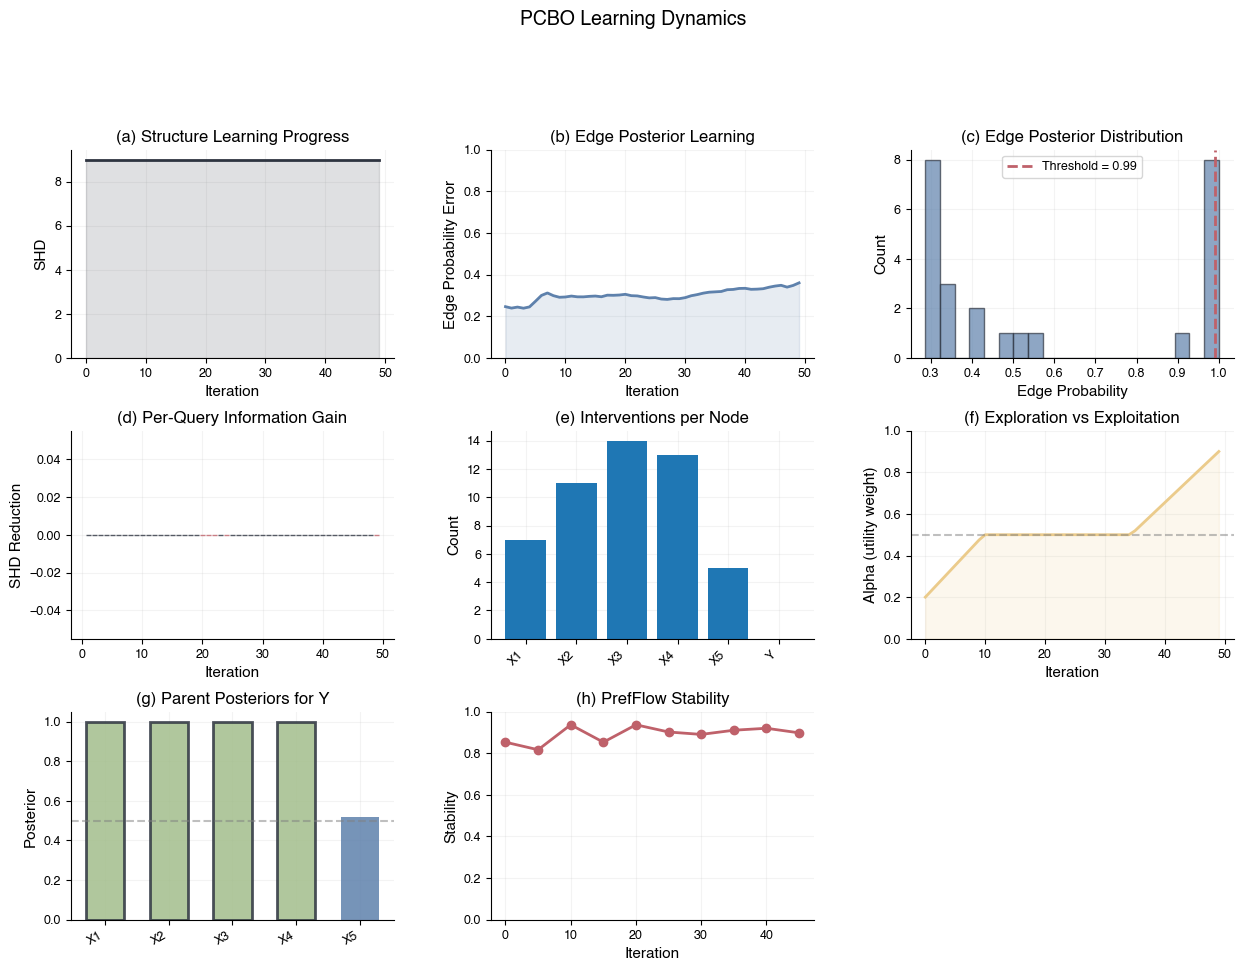

In [130]:
fig = plt.figure(figsize=(15, 10))
gs  = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

# (a) SHD progress
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(pcbo.iteration_history, pcbo.graph_distances, color=COLORS['primary'], linewidth=2)
ax1.fill_between(pcbo.iteration_history, 0, pcbo.graph_distances, alpha=0.15, color=COLORS['primary'])
ax1.set_xlabel('Iteration'); ax1.set_ylabel('SHD'); ax1.set_title('(a) Structure Learning Progress'); ax1.set_ylim(bottom=0)

# (b) Edge prob error
ax2 = fig.add_subplot(gs[0,1])
ax2.plot(pcbo.iteration_history, pcbo.edge_prob_errors, color=COLORS['secondary'], linewidth=2)
ax2.fill_between(pcbo.iteration_history, 0, pcbo.edge_prob_errors, alpha=0.15, color=COLORS['secondary'])
ax2.set_xlabel('Iteration'); ax2.set_ylabel('Edge Probability Error'); ax2.set_title('(b) Edge Posterior Learning'); ax2.set_ylim([0,1])

# (c) Edge posterior distribution + threshold
ax3 = fig.add_subplot(gs[0,2])
m = _offdiag_flat(P_full); P_flat = P_full[m].ravel()
P_flat = P_flat[P_flat>1e-3]
ax3.hist(P_flat, bins=20, color=COLORS['secondary'], alpha=0.7, edgecolor=COLORS['primary'])
ax3.axvline(t_star, color=COLORS['accent'], linestyle='--', linewidth=2, label=f'Threshold = {t_star:.2f}')
ax3.set_xlabel('Edge Probability'); ax3.set_ylabel('Count'); ax3.set_title('(c) Edge Posterior Distribution')
ax3.legend(loc='best')

# (d) Per-query info gain (ΔSHD)
ax4 = fig.add_subplot(gs[1,0])
if len(pcbo.graph_distances)>1:
    ig = -np.diff(pcbo.graph_distances, prepend=pcbo.graph_distances[0])
    bars = ax4.bar(pcbo.iteration_history[1:], ig[1:], color=COLORS['info'], alpha=0.8, edgecolor=COLORS['primary'])
    top = np.argsort(ig[1:])[-5:]
    for idx in top: bars[idx].set_color(COLORS['accent'])
ax4.set_xlabel('Iteration'); ax4.set_ylabel('SHD Reduction'); ax4.set_title('(d) Per-Query Information Gain')

# (e) Interventions per node
ax5 = fig.add_subplot(gs[1,1])
if pcbo.selected_interventions:
    counts = pd.Series([n for n,_ in pcbo.selected_interventions]).value_counts().reindex(range(pcbo.n_nodes), fill_value=0)
    ax5.bar(range(pcbo.n_nodes), counts.values)
    ax5.set_xticks(range(pcbo.n_nodes)); ax5.set_xticklabels(pcbo.node_names, rotation=45, ha='right')
    ax5.set_ylabel('Count'); ax5.set_title('(e) Interventions per Node')

# (f) alpha schedule
ax6 = fig.add_subplot(gs[1,2])
alphas = [pcbo._compute_acquisition_weight(i) for i in range(len(pcbo.iteration_history) or 1)]
ax6.plot(alphas, color=COLORS['warning'], linewidth=2)
ax6.fill_between(range(len(alphas)), 0, alphas, alpha=0.15, color=COLORS['warning'])
ax6.set_xlabel('Iteration'); ax6.set_ylabel('Alpha (utility weight)'); ax6.set_title('(f) Exploration vs Exploitation'); ax6.set_ylim([0,1]); ax6.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# (g) Parent posteriors for Y (compact)
ax7 = fig.add_subplot(gs[2,0])
lp_y = pcbo.local_posts[pcbo.y_idx]
pp   = _to_np(lp_y.edge_posterior()); parents = [pcbo.node_names[i] for i in lp_y.parent_idx]
true_mask = (true_adj_np[lp_y.parent_idx, pcbo.y_idx]==1)
x = np.arange(len(parents))
bars = ax7.bar(x, pp, color=COLORS['secondary'], alpha=0.85, width=0.6)
for k,b in enumerate(bars):
    if true_mask[k]: b.set_color(COLORS['success']); b.set_edgecolor(COLORS['primary']); b.set_linewidth(2)
ax7.set_xticks(x); ax7.set_xticklabels(parents, rotation=30, ha='right')
ax7.set_ylim(0,1.05); ax7.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax7.set_ylabel('Posterior'); ax7.set_title(f'(g) Parent Posteriors for {pcbo.node_names[pcbo.y_idx]}')

# (h) PrefFlow stability (keep)
ax8 = fig.add_subplot(gs[2,1])
stab = []
win = 5
for i in range(0, len(pcbo.utility_errors), win):
    w = pcbo.utility_errors[i:i+win]
    if w: stab.append(1 - np.std(w))
if stab:
    ax8.plot(range(0, len(pcbo.utility_errors), win), stab, color=COLORS['accent'], linewidth=2, marker='o')
ax8.set_xlabel('Iteration'); ax8.set_ylabel('Stability'); ax8.set_title('(h) PrefFlow Stability'); ax8.set_ylim([0,1])

plt.suptitle('PCBO Learning Dynamics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
if SAVE_FIGS: 
				plt.savefig(os.path.join(FIG_DIR, f'pcbo_convergence_{n_nodes}_nodes.pdf'), dpi=300, bbox_inches='tight')
plt.show()

### Graphs

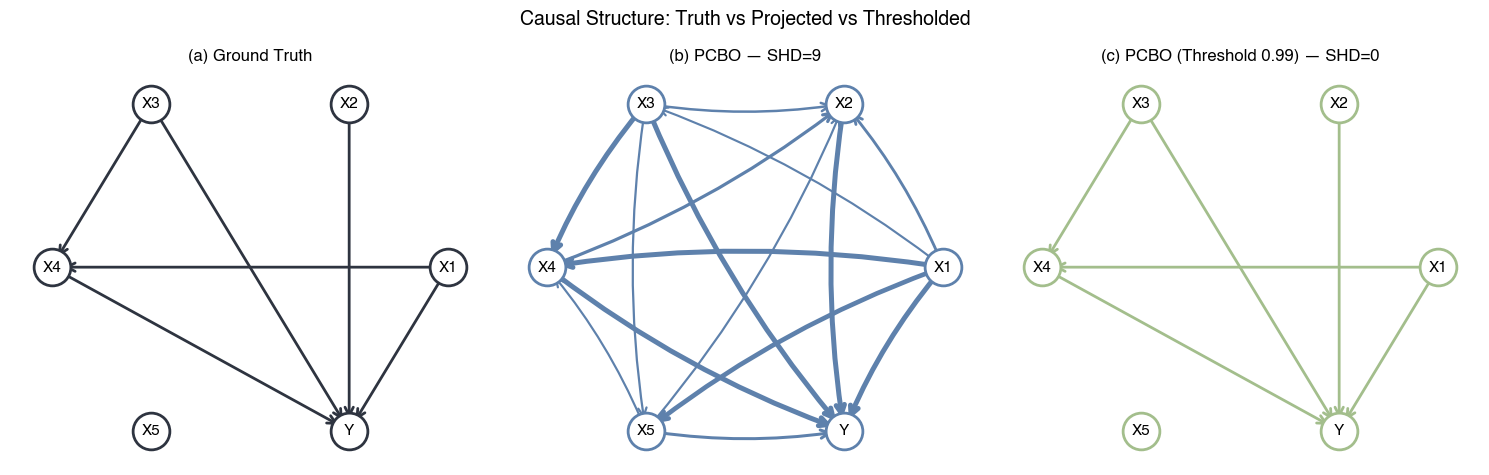

In [131]:
LAYOUT = "circular"
G_true = nx.DiGraph(true_adj_np)
pos = (nx.spring_layout(G_true, seed=42) if LAYOUT=="spring" else
       nx.kamada_kawai_layout(G_true)   if LAYOUT=="kamada_kawai" else
       nx.circular_layout(G_true))

fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
# (a) Truth
ax = axes[0]
nx.draw_networkx_nodes(G_true, pos, ax=ax, node_color='white', node_size=700, linewidths=2, edgecolors=COLORS['primary'])
nx.draw_networkx_edges(G_true, pos, ax=ax, edge_color=COLORS['primary'], width=2, arrowsize=15, arrowstyle='->')
nx.draw_networkx_labels(G_true, pos, ax=ax, font_size=11, font_weight='semibold', labels={i: pcbo.node_names[i] for i in G_true.nodes()})
ax.set_title('(a) Ground Truth'); ax.axis('off')

# (b) Projected (thickness ∝ P_full)
ax = axes[1]
G_proj = nx.DiGraph(A_proj)
nx.draw_networkx_nodes(G_proj, pos, ax=ax, node_color='white', node_size=700, linewidths=2, edgecolors=COLORS['secondary'])
for (i,j) in G_proj.edges():
    w = P_full[i,j]*3.0 + 0.6
    nx.draw_networkx_edges(G_proj, pos, ax=ax, edgelist=[(i,j)], edge_color=COLORS['secondary'], width=w, arrowsize=15, arrowstyle='->', connectionstyle='arc3,rad=0.08')
nx.draw_networkx_labels(G_proj, pos, ax=ax, font_size=11, font_weight='semibold', labels={i: pcbo.node_names[i] for i in G_proj.nodes()})
ax.set_title(f'(b) PCBO — SHD={m_proj["shd"]}'); ax.axis('off')

# (c) Thresholded
ax = axes[2]
G_thr = nx.DiGraph(A_thrproj)
nx.draw_networkx_nodes(G_thr, pos, ax=ax, node_color='white', node_size=700, linewidths=2, edgecolors=COLORS['success'])
nx.draw_networkx_edges(G_thr, pos, ax=ax, edge_color=COLORS['success'], width=2, arrowsize=15, arrowstyle='->')
nx.draw_networkx_labels(G_thr, pos, ax=ax, font_size=11, font_weight='semibold', labels={i: pcbo.node_names[i] for i in G_thr.nodes()})
ax.set_title(f'(c) PCBO (Threshold {t_star:.2f}) — SHD={m_thr["shd"]}'); ax.axis('off')

plt.suptitle('Causal Structure: Truth vs Projected vs Thresholded', fontsize=14, fontweight='bold')
plt.tight_layout()
if SAVE_FIGS: 
     plt.savefig(os.path.join(FIG_DIR, f'graphs_truth_proj_thresh_{n_nodes}_nodes.pdf'), dpi=300, bbox_inches='tight')
plt.show()

### Confusion Matrices

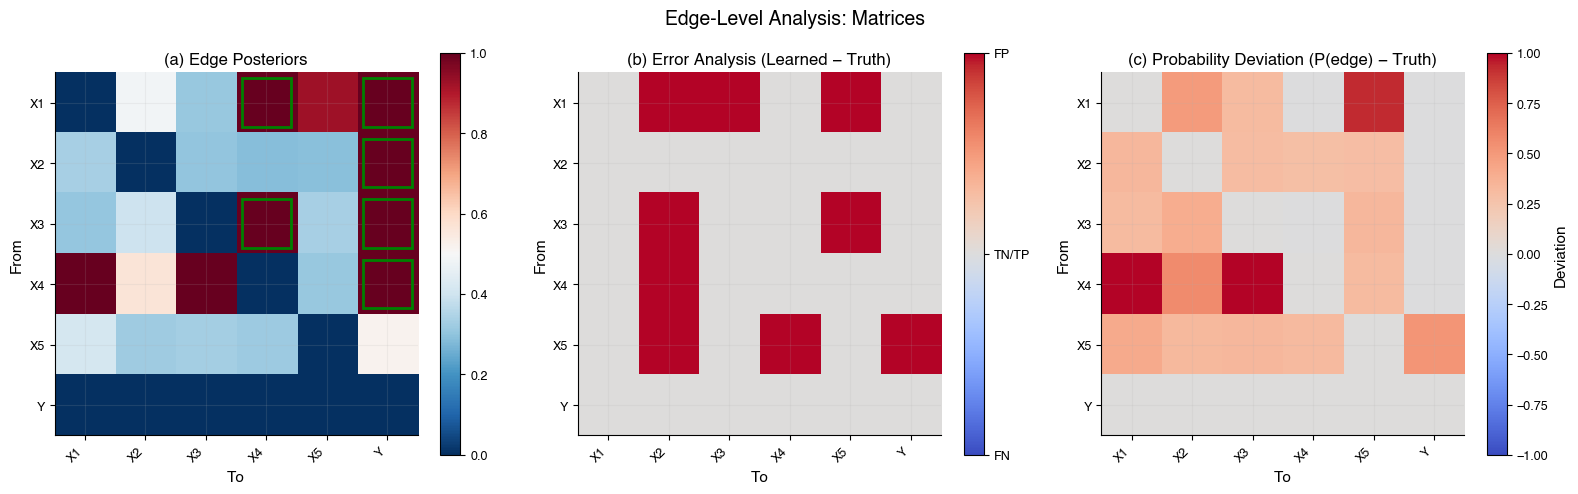

In [132]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4.8))

# (a) Edge posteriors
ax = axes[0]
im = ax.imshow(P_full, cmap='RdBu_r', vmin=0, vmax=1)
ax.set_xticks(range(pcbo.n_nodes)); ax.set_yticks(range(pcbo.n_nodes))
ax.set_xticklabels(pcbo.node_names, rotation=45, ha='right'); ax.set_yticklabels(pcbo.node_names)
ax.set_xlabel('To'); ax.set_ylabel('From'); ax.set_title('(a) Edge Posteriors')
for i in range(pcbo.n_nodes):
    for j in range(pcbo.n_nodes):
        if true_adj_np[i, j] == 1:
            ax.add_patch(plt.Rectangle((j-0.4, i-0.4), 0.8, 0.8,
                                       fill=False, edgecolor='green', linewidth=2))
plt.colorbar(im, ax=ax)

# (b) Binary error (projected − truth)
ax = axes[1]
diff = A_proj.astype(int) - true_adj_np.astype(int)
im2 = ax.imshow(diff, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(pcbo.n_nodes)); ax.set_yticks(range(pcbo.n_nodes))
ax.set_xticklabels(pcbo.node_names, rotation=45, ha='right'); ax.set_yticklabels(pcbo.node_names)
ax.set_xlabel('To'); ax.set_ylabel('From'); ax.set_title('(b) Error Analysis (Learned − Truth)')
cbar = plt.colorbar(im2, ax=ax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['FN', 'TN/TP', 'FP'])

# (c) Probability deviation (P − truth)
ax = axes[2]
dev = P_full - true_adj_np
im3 = ax.imshow(dev, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(pcbo.n_nodes)); ax.set_yticks(range(pcbo.n_nodes))
ax.set_xticklabels(pcbo.node_names, rotation=45, ha='right'); ax.set_yticklabels(pcbo.node_names)
ax.set_xlabel('To'); ax.set_ylabel('From'); ax.set_title('(c) Probability Deviation (P(edge) − Truth)')
plt.colorbar(im3, ax=ax, label='Deviation')

plt.suptitle('Edge-Level Analysis: Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(FIG_DIR, f'matrices_{n_nodes}_nodes.pdf'), dpi=300, bbox_inches='tight')
plt.show()

### PR & ROC Curves

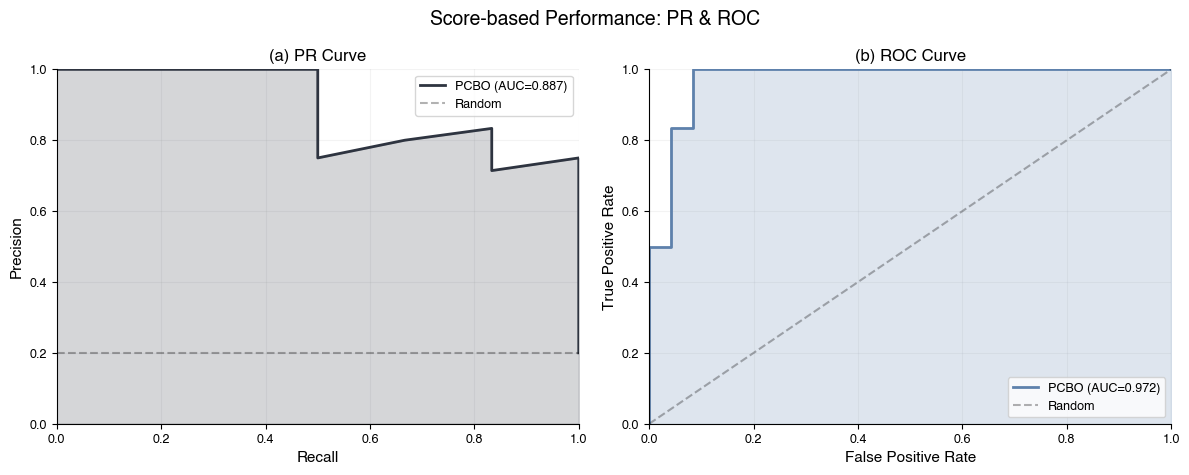

In [133]:
mask = ~np.eye(true_adj_np.shape[0], dtype=bool)
y_true = true_adj_np[mask].ravel().astype(int)
y_score = P_full[mask].ravel()

prec, rec, _ = precision_recall_curve(y_true, y_score)
pr_auc_val = auc(rec, prec)
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc_val = roc_auc_score(y_true, y_score)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))

# (a) PR Curve
ax = axes[0]
ax.plot(rec, prec, color=COLORS['primary'], linewidth=2, label=f'PCBO (AUC={pr_auc_val:.3f})')
ax.fill_between(rec, prec, alpha=0.2, color=COLORS['primary'])
ax.plot([0, 1], [y_true.mean(), y_true.mean()], 'k--', alpha=0.3, label='Random')
ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
ax.set_title('(a) PR Curve'); ax.set_xlim([0, 1]); ax.set_ylim([0, 1])
ax.legend(loc='best')

# (b) ROC Curve
ax = axes[1]
ax.plot(fpr, tpr, color=COLORS['secondary'], linewidth=2, label=f'PCBO (AUC={roc_auc_val:.3f})')
ax.fill_between(fpr, tpr, alpha=0.2, color=COLORS['secondary'])
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
ax.set_title('(b) ROC Curve'); ax.set_xlim([0, 1]); ax.set_ylim([0, 1])
ax.legend(loc='best')

plt.suptitle('Score-based Performance: PR & ROC', fontsize=14, fontweight='bold')
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(FIG_DIR, f'pr_roc_curves_{n_nodes}_nodes.pdf'), dpi=300, bbox_inches='tight')
plt.show()

### Preference Learning with Normalizing Flows

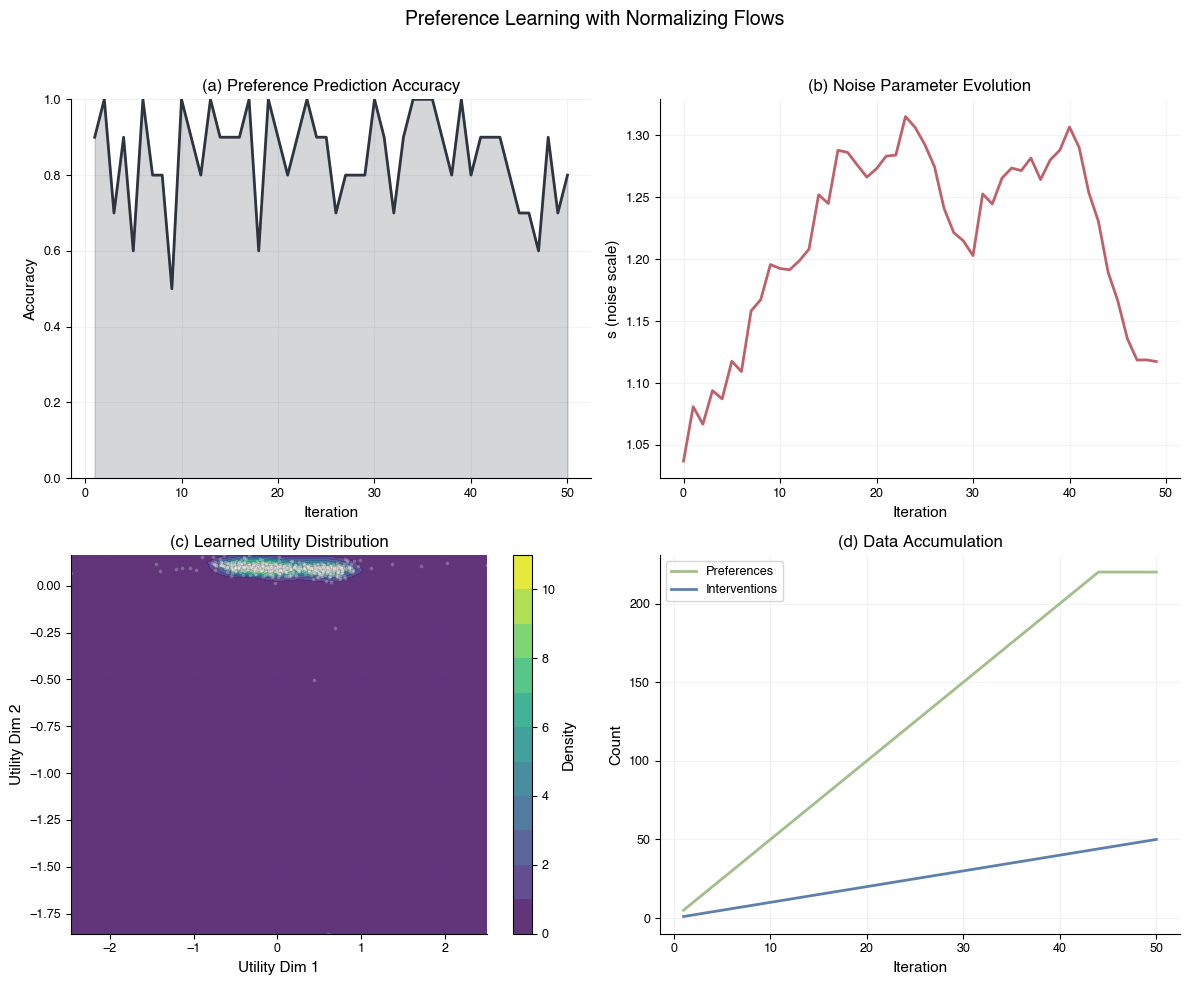

In [134]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Preference Learning with Normalizing Flows', fontsize=14, fontweight='bold')

# (a) Preference prediction accuracy over iterations
ax = axes[0, 0]
pref_acc = 1 - np.array(pcbo.utility_errors, dtype=float) if pcbo.utility_errors else np.array([])
if pref_acc.size:
    ax.plot(range(1, len(pref_acc)+1), pref_acc, color=COLORS['primary'], linewidth=2)
    ax.fill_between(range(1, len(pref_acc)+1), 0, pref_acc, alpha=0.2, color=COLORS['primary'])
ax.set_xlabel('Iteration'); ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1]); ax.set_title('(a) Preference Prediction Accuracy')

# (b) Noise parameter s over iterations
ax = axes[0, 1]
iters = np.array(pcbo.iteration_history, dtype=float)
s_hist = np.array(getattr(pcbo, "s_history_iter", []), dtype=float)
# Align lengths for plotting
if iters.size and s_hist.size:
    if s_hist.size < iters.size:
        s_hist = np.pad(s_hist, (0, iters.size - s_hist.size), constant_values=np.nan)
    elif s_hist.size > iters.size:
        s_hist = s_hist[:iters.size]
    ax.plot(iters, s_hist, color=COLORS['accent'], linewidth=2)
else:
    # fallback: plot constant current value to indicate availability
    ax.plot([0, 1], [pcbo.pref_flow.s.item()]*2, color=COLORS['accent'], linewidth=2)
ax.set_xlabel('Iteration'); ax.set_ylabel('s (noise scale)')
ax.set_title('(b) Noise Parameter Evolution')

# (c) Learned utility distribution (2D projection)
ax = axes[1, 0]
with torch.no_grad():
    try:
        samples, _ = pcbo.pref_flow.sample_stable(1000)  # (N, d_util)
        samples = samples.cpu().numpy()
        if samples.shape[1] >= 2 and samples.shape[0] > 10:
            x, y = samples[:, 0], samples[:, 1]
            xi, yi = np.mgrid[x.min():x.max():50j, y.min():y.max():50j]
            kde = gaussian_kde(np.vstack([x, y]))
            zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
            im = ax.contourf(xi, yi, zi, levels=12, cmap='viridis', alpha=0.85)
            plt.colorbar(im, ax=ax, label='Density')
            ax.scatter(x, y, s=8, alpha=0.25, color='white', edgecolor='black', linewidth=0.2)
        else:
            ax.text(0.5, 0.5, "Utility space < 2D or too few samples", ha='center', va='center')
    except Exception as e:
        ax.text(0.5, 0.5, f"Sampling error: {e}", ha='center', va='center')
ax.set_xlabel('Utility Dim 1'); ax.set_ylabel('Utility Dim 2')
ax.set_title('(c) Learned Utility Distribution')

# (d) Data accumulation (preferences & interventions)
ax = axes[1, 1]
T = len(pcbo.iteration_history)
# Approximate prefs growth if only final set is stored
prefs_over_time = [min(len(pcbo.pref_dataset), (i+1)*5) for i in range(T)] if T else []
intervs_over_time = list(range(1, T+1)) if T else []
if prefs_over_time:
    ax.plot(range(1, T+1), prefs_over_time, color=COLORS['success'], linewidth=2, label='Preferences')
if intervs_over_time:
    ax.plot(range(1, T+1), intervs_over_time, color=COLORS['secondary'], linewidth=2, label='Interventions')
ax.set_xlabel('Iteration'); ax.set_ylabel('Count')
ax.set_title('(d) Data Accumulation'); ax.legend(loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 0.96])
if SAVE_FIGS:
    plt.savefig(os.path.join(FIG_DIR, f"preference_learning_{n_nodes}_nodes.pdf"), dpi=300, bbox_inches='tight')
plt.show()